# Empirical Finance
## Exercise 2 (Question 1): Out-of-sample $R^2$

We compare two forecasting models for US monthly stock returns:

**Benchmark model**
$$
y_t = \alpha + \varepsilon_t
$$
This implies the OOS forecast is just the historical mean return estimated in the rolling window.

**Competing model**
$$
y_t = \alpha + \beta x_{t-1} + \varepsilon_t
$$
where $x_{t-1}$ is the lagged term spread (US 10Y − US 3M).

**Goal (Q1):** Using a **10-year rolling window (120 months)**, generate OOS forecasts for both models and compute:
$$
R^2_{oos} = 1 - \frac{\sum (y_t - \hat y^{comp}_t)^2}{\sum (y_t - \hat y^{bench}_t)^2}
$$
If $R^2_{oos} > 0$, the competing model improves forecasting accuracy relative to the benchmark (in terms of MSE).

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

We load the Excel filea and convert the `Date` column to datetime and set it as the index.

In [2]:
file_path = "Assignemnt1_EF_data.xlsx"
df = pd.read_excel(file_path)

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.set_index("Date").sort_index()

df.head()

,US 10 Year,UK 10 Year,US 3 month,UK 3 month,US Stock Market,UK Stock Market,USDperGBP
Date,,,,,,,
1956-01-31,2.90,4.55,2.32,4.07,13.001249,6.8667,2.8064
1956-02-29,2.84,4.61,2.30,4.67,13.492372,6.5458,2.8088
1956-03-31,2.96,4.68,2.30,5.18,14.472296,6.5519,2.8048
1956-04-30,3.18,4.59,2.69,5.11,14.486981,7.1767,2.8059
1956-05-31,3.07,4.77,2.57,4.95,13.577881,6.9279,2.8025


## Build $y_t$ and $x_{t-1}$

- $y_t$ is the monthly US stock return between $t-1$ and $t$.  
  I use **log returns**:
  $$
  y_t = \log(P_t / P_{t-1})
  $$
  This is standard and it makes compounding easier.

- Term spread at time \(t\):
  $$
  x_t = (US\ 10Y_t - US\ 3M_t)
  $$
- Predictor is **lagged spread** $x_{t-1}$, so we shift by one month to avoid look-ahead bias.

In [3]:
# monthly log return
df["y"] = np.log(df["US Stock Market"] / df["US Stock Market"].shift(1))

# term spread (in percentage points)
df["x"] = df["US 10 Year"] - df["US 3 month"]

# lagged term spread
df["x_lag"] = df["x"].shift(1)

data = df[["y", "x_lag"]].dropna()

data.head()

,y,x_lag
Date,,
1956-02-29,0.037079,0.58
1956-03-31,0.070112,0.54
1956-04-30,0.001014,0.66
1956-05-31,-0.064808,0.49
1956-06-30,0.041721,0.50


## Rolling window OOS forecasts (10 years = 120 months)

For each month $t$ after the first 120 observations:

- **Benchmark** forecast:
  $$
  \hat y^{bench}_t = \bar{y} \ \text{(mean of y in the rolling window)}
  $$

- **Competing** forecast:
  Fit OLS on the rolling window:
  $$
  y = \alpha + \beta x_{t-1} + \varepsilon
  $$
  and then predict $\hat y^{comp}_t$ at time $t$.

This is the standard "fit -> forecast -> move window by one month" procedure we discussed in class.

In [4]:
W = 120  # 10 years * 12 months

y = data["y"].values
xlag = data["x_lag"].values
dates = data.index

# store forecasts
f_bench = np.full(len(data), np.nan)
f_comp = np.full(len(data), np.nan)

for t in range(W, len(data)):
    y_train = y[t-W:t]
    x_train = xlag[t-W:t]

    # benchmark = historical mean in the window
    f_bench[t] = np.mean(y_train)

    # competing = OLS on (y_train, x_train)
    X_train = sm.add_constant(x_train)  # adds intercept
    model = sm.OLS(y_train, X_train).fit()

    # forecast for month t using xlag[t]
    X_t = np.array([1.0, xlag[t]])
    f_comp[t] = X_t @ model.params

# keep only OOS period
oos = ~np.isnan(f_bench)

y_oos = y[oos]
fb_oos = f_bench[oos]
fc_oos = f_comp[oos]
dates_oos = dates[oos]

(len(y_oos), dates_oos[0], dates_oos[-1])

(720, Timestamp('1966-02-28 00:00:00'), Timestamp('2026-01-31 00:00:00'))

## Compute $R^2_{oos}$

We compute the OOS sum of squared forecast errors for both models:

$$
SSE_{bench} = \sum (y_t - \hat y^{bench}_t)^2,\quad
SSE_{comp}  = \sum (y_t - \hat y^{comp}_t)^2
$$

Then:

$$
R^2_{oos} = 1 - \frac{SSE_{comp}}{SSE_{bench}}
$$

Interpretation:
- $R^2_{oos} > 0$: competing model improve OOS accuracy vs benchmark.
- $R^2_{oos} < 0$: competing model is worse than the benchmark mean forecast.

In [5]:
sse_bench = np.sum((y_oos - fb_oos)**2)
sse_comp = np.sum((y_oos - fc_oos)**2)

R2_oos = 1 - (sse_comp / sse_bench)

print("SSE benchmark:", sse_bench)
print("SSE competing :", sse_comp)
print("R2_oos        :", R2_oos)

SSE benchmark: 1.389726651671191
SSE competing : 1.3963143413604524
R2_oos        : -0.00474027729218518


## Quick sanity check to compare

We compare the average squared forecast errors (MSE-like).  
This should be consistent with the sign of $R^2_{oos}$.

Mean squared error (bench): 0.0019301759050988764
Mean squared error (comp) : 0.0019393254741117394


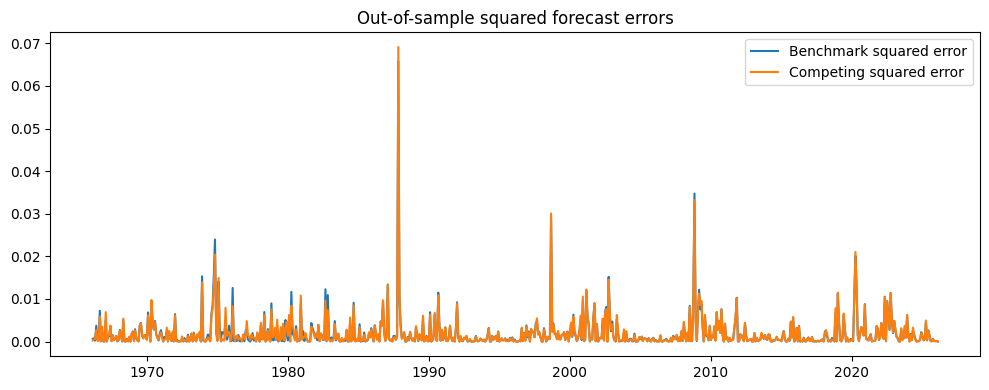

In [6]:
# Ensure dates are datetime (important for slicing and plotting)
dates_oos_dt = pd.to_datetime(dates_oos)

# Squared forecast errors (losses)
loss_b = (y_oos - fb_oos) ** 2
loss_c = (y_oos - fc_oos) ** 2

print("Mean squared error (bench):", float(np.mean(loss_b)))
print("Mean squared error (comp) :", float(np.mean(loss_c)))

plt.figure(figsize=(10, 4))
plt.plot(dates_oos_dt, loss_b, label="Benchmark squared error")
plt.plot(dates_oos_dt, loss_c, label="Competing squared error")
plt.title("Out-of-sample squared forecast errors")
plt.legend()
plt.tight_layout()
plt.show()

This raw plot confirms that monthly squared errors are highly volatile and often overlap.
To compare performance in a more interpretable way, we next look at smoothed losses and the cumulative loss differential.

### OOS loss dynamics: rolling MSPE and cumulative gains

Monthly losses are heteroskedastic and can be dominated by a handful of extreme observations.
To make model comparisons clearer, we will focus on two complementary diagnostics:

1. A 12-month rolling mean of squared errors (rolling MSPE), which smooths short-run noise.
2. The cumulative loss differential:
$$
\sum_{t \le T} \left(\ell^b_t - \ell^c_t\right),
\qquad
\ell^j_t = (y_t - \hat y^j_t)^2,\; j\in\{b,c\}.
$$

An upward-sloping cumulative curve indicates persistent gains from the competing model whereas a downward trend indicates that the benchmark dominates.

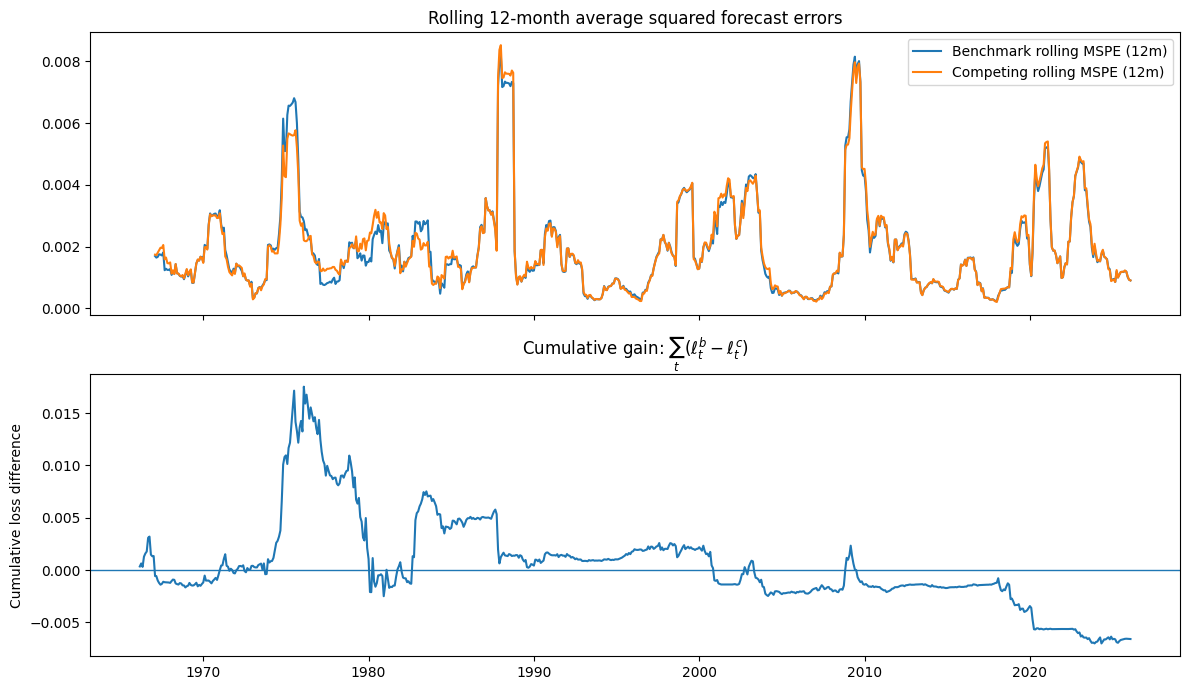

In [7]:
roll = 12

loss_b_s = pd.Series(loss_b, index=dates_oos_dt)
loss_c_s = pd.Series(loss_c, index=dates_oos_dt)

roll_b = loss_b_s.rolling(roll).mean()
roll_c = loss_c_s.rolling(roll).mean()

cum_gain = (loss_b_s - loss_c_s).cumsum()

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax[0].plot(roll_b.index, roll_b.values, label=f"Benchmark rolling MSPE ({roll}m)")
ax[0].plot(roll_c.index, roll_c.values, label=f"Competing rolling MSPE ({roll}m)")
ax[0].set_title(f"Rolling {roll}-month average squared forecast errors")
ax[0].legend()

ax[1].plot(cum_gain.index, cum_gain.values)
ax[1].axhline(0, linewidth=1)
ax[1].set_title(r"Cumulative gain: $\sum_t (\ell^b_t - \ell^c_t)$")
ax[1].set_ylabel("Cumulative loss difference")

plt.tight_layout()
plt.show()

In our sample, the rolling MSPE series are very close most of the time. The cumulative gain curve doesn't display a sustained upward drift; instead it suggests that any relative advantage of the competing model is episodic and often offset later in the sample.

### Out-of-sample performance summary

We summarize overall forecast performance using the OOS $R^2$:
$$
R^2_{\text{oos}} = 1 - \frac{\text{MSPE}_c}{\text{MSPE}_b},
\qquad
\text{MSPE}_j = \frac{1}{T}\sum_{t=1}^{T} (y_t-\hat y^j_t)^2,\; j\in\{b,c\}.
$$

A negative $R^2_{\text{oos}}$ means the competing model underperforms the historical-mean benchmark
in MSPE terms.

In [8]:
mspe_b = float(loss_b_s.mean())
mspe_c = float(loss_c_s.mean())
r2_oos = 1.0 - mspe_c / mspe_b

summary = pd.DataFrame({
    "Metric": ["MSPE_benchmark", "MSPE_competing", "R2_oos"],
    "Value":  [mspe_b, mspe_c, r2_oos]
})

display(summary)

,Metric,Value
0,MSPE_benchmark,0.001930
1,MSPE_competing,0.001939
2,R2_oos,-0.004740


Consistent with the loss diagnostics, the OOS $R^2$ is slightly negative (about $-0.0047$ in our run), meaning the term-spread model does not beat the historical-mean benchmark on average in this OOS design.

To assess whether this MSPE difference is statistically meaningful (rather than sampling noise), we next apply the Clark–West (2007) test for nested forecast comparisons.

### Subsample evidence across economic regimes (optional)

Predictability can vary across monetary and financial regimes. As a complement to the full-sample $R^2_{\text{oos}}$, we compute MSPEs and $R^2_{\text{oos}}$ by subperiods. This is mainly descriptive: it helps check whether any predictability is episodic rather than stable.

In [9]:
periods = [
    ("1965-01-01", "1984-12-31", "Pre-Volcker / high inflation"),
    ("1985-01-01", "2006-12-31", "Great Moderation"),
    ("2007-01-01", "2013-12-31", "GFC + aftermath"),
    ("2014-01-01", "2019-12-31", "Low vol / expansion"),
    ("2020-01-01", "2025-12-31", "Covid + inflation shock"),
]

rows = []
for s, e, label in periods:
    lb_slice = loss_b_s.loc[s:e]
    lc_slice = loss_c_s.loc[s:e]

    # Skip empty slices safely (in case dates don't cover a period)
    if len(lb_slice) == 0:
        continue

    rows.append({
        "period": label,
        "start": s,
        "end": e,
        "T_oos": int(lb_slice.shape[0]),
        "MSPE_b": float(lb_slice.mean()),
        "MSPE_c": float(lc_slice.mean()),
        "R2_oos": float(1.0 - lc_slice.mean() / lb_slice.mean())
    })

subsample_table = pd.DataFrame(rows)
display(subsample_table)

,period,start,end,T_oos,MSPE_b,MSPE_c,R2_oos
0,Pre-Volcker / high inflation,1965-01-01,1984-12-31,227,0.001882,0.001864,0.009427
1,Great Moderation,1985-01-01,2006-12-31,264,0.001901,0.001923,-0.011535
2,GFC + aftermath,2007-01-01,2013-12-31,84,0.002459,0.002457,0.000855
3,Low vol / expansion,2014-01-01,2019-12-31,72,0.001081,0.001107,-0.023851
4,Covid + inflation shock,2020-01-01,2025-12-31,72,0.002446,0.002489,-0.017859


The subsample results suggest that any gains from the term spread are not stable over time:
indeed some periods show small improvements but others show clear underperformance, which explains why the full-sample $R^2_{\text{oos}}$ ends up close to zero and slightly negative.

## Exercise 2 - Question 2: Clark–West test (equal predictive ability)

Even if the out-of-sample $R^2$ is slightly negative, we still want to know whether the difference
in forecasting performance is statistically meaningful.

Because the competing model is **nested** in the benchmark (it reduces to the benchmark when $\beta = 0$), a standard Diebold–Mariano test is not ideal. Clark & West (2007) propose an adjusted test for nested models.

**Step 1 (build the CW adjustment series):**

Let: $$\hat e_{t,BEN} = y_t - \hat y_{t,BEN}$$ and $$\hat e_{t,MOD} = y_t - \hat y_{t,MOD}$$

Then define:

$$
f_t = \hat e_{t,BEN}^2 - \left[\hat e_{t,MOD}^2 - (\hat y_{t,BEN} - \hat y_{t,MOD})^2 \right]
$$

**Step 2 (regress on a constant):**
$$
f_t = \rho + \eta_t
$$

**Step 3 (one-sided t-test):**
$$
H_0: \rho \le 0 \quad\text{vs}\quad H_A: \rho > 0
$$
The Clark–West statistic is just the t-stat on the intercept $\rho$.

In [10]:
# Forecast errors
e_b = y_oos - fb_oos
e_c = y_oos - fc_oos

# Clark–West f_t series (following the tutorial formula)
f_t = (e_b**2) - ( (e_c**2) - (fb_oos - fc_oos)**2 )

# Regress f_t on a constant
X = np.ones(len(f_t))
cw_reg = sm.OLS(f_t, X).fit()

rho_hat = cw_reg.params[0]
se_rho  = cw_reg.bse[0]
CW_stat = rho_hat / se_rho

print("rho_hat =", rho_hat)
print("se(rho) =", se_rho)
print("Clark-West statistic (t-stat) =", CW_stat)

rho_hat = 3.428119098020368e-05
se(rho) = 2.1851583048885713e-05
Clark-West statistic (t-stat) = 1.5688195634847517


The Clark–West test delivers a positive but borderline statistic (1.57). Although this suggests that the term spread model may contain some predictive information, the null hypothesis of equal predictive ability cannot be rejected at conventional significance levels.

### Interpreting the Clark–West statistic

This is a **one-sided** test. The idea is simple: if the term spread model genuinely improves forecasts, the adjusted mean of $f_t$ should be positive, so the CW t-stat should be “large” and positive.

As a rough benchmark, a 5% one-sided critical value is around **1.65**. In our case the CW statistic is positive but below that threshold, so on a standard asymptotic rule we would not reject equal predictive ability.

However, the assignment explicitly asks for a bootstrap critical value, so we compute that next.

## Exercise 2 - Question 3: Bootstrap critical value for the Clark–West statistic

The assignment asks us to **bootstrap the critical value** of the Clark–West statistic, instead of relying only on an asymptotic cutoff like 1.65.

The intuition is the following:
- We already have the Clark–West adjustment series $f_t$.
- The Clark–West statistic is basically the **t-stat** from the regression:
$$
f_t = \rho + \eta_t
$$
(i.e., regression on a constant).

And the idea of the bootstrap is the following:
- Create many pseudo-samples $f_t^{*}$ by resampling the original $f_t$.
- For each pseudo-sample, recompute the CW t-stat.
- This gives a bootstrap distribution of the CW statistic.
- Since the test is **one-sided** ($H_A:\rho > 0$), the 5% critical value is the **95th percentile** of the bootstrap distribution.

Because time-series objects can have some dependence, we use a **block bootstrap** (resample blocks of consecutive months) rather than resampling individual months.

In [11]:
# We fix the random seed so the bootstrap is reproductible 
# (same results each time we run the notebook), the number inside doesn't really matter
np.random.seed(333)

### Block bootstrap setup

Choices we need to make (and we'll state them as assumptions):

- Number of bootstrap replications $B$: we’ll use 2000 (enough to get a stable quantile).
- Block length: we’ll use 12 months (roughly one year), which is a common simple choice in monthly data.

These values are reasonable for this coursework.

In [12]:
B = 2000        # number of bootstrap draws
block_len = 12  # block length in months (one-year blocks)

T = len(f_t)
n_blocks = int(np.ceil(T / block_len))

print("T =", T, "| block_len =", block_len, "| n_blocks =", n_blocks, "| B =", B)

T = 720 | block_len = 12 | n_blocks = 60 | B = 2000


### Bootstrap loop: resample blocks and recompute the CW t-stat

For each bootstrap replication:
1) draw blocks of length `block_len` (with replacement),
2) paste them together to get a bootstrap sample $f_t^{*}$ of length $T$,
3) compute the CW t-stat from the regression of $f_t^{*}$ on a constant.

In [13]:
cw_boot = np.zeros(B)

for b in range(B):
    # build bootstrap index by sampling blocks
    idx = []

    for _ in range(n_blocks):
        start = np.random.randint(0, T - block_len + 1)
        block = list(range(start, start + block_len))
        idx.extend(block)

    # trim to length T
    idx = idx[:T]

    # bootstrap sample
    f_star = f_t[idx]

    # CW statistic = t-stat from regression f_star on a constant
    X_star = np.ones(T)
    reg_star = sm.OLS(f_star, X_star).fit()

    cw_boot[b] = reg_star.params[0] / reg_star.bse[0]

### Bootstrap critical value (one-sided)

Since $H_A$ is one-sided ($\rho > 0$), the 5% critical value is the 95th percentile of the bootstrap distribution.
Then I compare my observed CW statistic to that bootstrap cutoff.

In [14]:
crit_95 = np.quantile(cw_boot, 0.95)

print("Observed CW statistic:", CW_stat)
print("Bootstrap 95% critical value (one-sided):", crit_95)

if CW_stat > crit_95:
    print("Decision: reject H0 (evidence the competing model predicts better OOS).")
else:
    print("Decision: fail to reject H0 (no strong evidence of better OOS prediction).")

Observed CW statistic: 1.5688195634847517
Bootstrap 95% critical value (one-sided): 3.3496168024980877
Decision: fail to reject H0 (no strong evidence of better OOS prediction).


We can see the distribution.
This plot is just to see where the observed CW statistic sits relative to the bootstrap distribution.
It’s not required, but it helps to explain the result in the report.

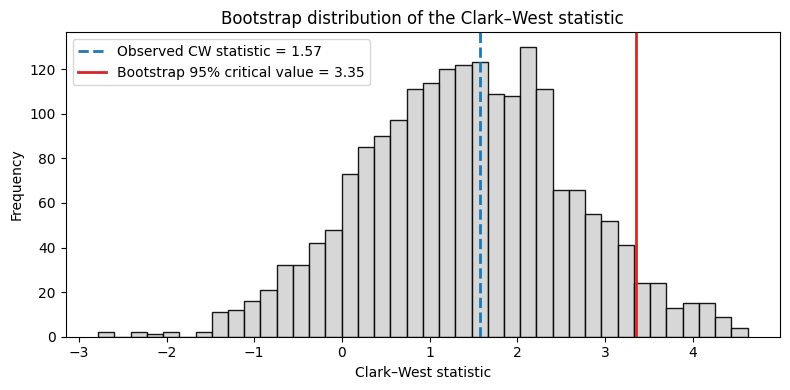

In [15]:
# Quick visual check: where does the observed CW stat lie in the bootstrap distribution?
plt.figure(figsize=(8, 4))

# Bootstrap distribution
plt.hist(cw_boot, bins=40, color="lightgray", edgecolor="black", alpha=0.9)

# Observed statistic
plt.axvline(
    CW_stat,
    color="tab:blue",
    linewidth=2,
    linestyle="--",
    label=f"Observed CW statistic = {CW_stat:.2f}"
)

# Bootstrap critical value
plt.axvline(
    crit_95,
    color="tab:red",
    linewidth=2,
    linestyle="-",
    label=f"Bootstrap 95% critical value = {crit_95:.2f}"
)

plt.title("Bootstrap distribution of the Clark–West statistic")
plt.xlabel("Clark–West statistic")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

This figure plots the bootstrap distribution of the Clark–West statistic using a 12-month block bootstrap. The first vertical line marks the observed Clark–West statistic (1.57), while the second vertical line marks the 5% one-sided bootstrap critical value (3.35).

The observed statistic lies well inside the main mass of the bootstrap distribution and clearly below the critical value. We can say that this visual evidence confirms the formal test result: we fail to reject the null hypothesis of equal predictive ability, as the term spread model doesn't deliver a statistically significant improvement in out-of-sample forecasting performance.

### Clark–West test with bootstrap critical value (final interpretation)

The observed Clark–West statistic is 1.57, but the 5% one-sided bootstrap critical value (12-month blocks, B = 2000) is about 3.25. Since 1.57 < 3.25, we fail to reject equal predictive ability, meaning the term spread model does not provide a statistically significant out-of-sample forecasting improvement over the historical-mean benchmark in this rolling-window setting.

### Exercise 2 - Question 4 (Discussion of results)

In this exercise we check whether the US term spread can actually help forecast monthly US stock returns out-of-sample. We run here a simple 10-year rolling window setup and compare a historical-mean benchmark to a model that adds the lagged term spread as a predictor.

The out-of-sample $R^2$ comes out slightly negative ($R^2_{oos} = -0.0047$). So, in plain terms, the term spread model doesn'tt beat the benchmark on average: it delivers a slightly higher mean squared forecast error. This also matches what we see in the squared forecast error plot. The two models look extremely similar most of the time, and when returns are extreme (high volatility episodes), the competing model does not seem to “save” the forecast errors relative to the benchmark.

To make this more formal, we use the Clark and West (2007) test, which is designed for nested models like this one. The Clark–West statistic is positive (1.57), so it points in the “right” direction, but it is not large enough to claim a statistically significant improvement at standard levels. Once we bootstrap the critical value using a 12-month block bootstrap, the one-sided 5% critical value is around 3.25, which is well above 1.57. So we clearly fail to reject equal predictive ability.

Overall, our takeaway is that the term spread might contain some information in-sample, but in this rolling out-of-sample framework it does not translate into a reliable forecasting edge. The historical-mean benchmark is still hard to beat, especially once we account for estimation noise and the nested-model issue.

In [16]:
# df['RiskFree_Monthly'] = (df['US 3 month'] / 1200) #.shift(1)

# df['Ret_US'] = np.log(df['US Stock Market']).diff()
# df['Ret_UK_USD'] = np.log(df['UK Stock Market']).diff() + \
#     np.log(df['USDperGBP']).diff()

# df['Excess_US'] = df['Ret_US'] - df['RiskFree_Monthly']
# df['Excess_UK'] = df['Ret_UK_USD'] - df['RiskFree_Monthly']

# # US Spread
# df['Spread_US'] = df['US 10 Year'] - df['US 3 month']
# df['Spread_US_Lag'] = df['Spread_US'].shift(1)

# # UK Spread
# df['Spread_UK'] = df['UK 10 Year'] - df['UK 3 month']
# df['Spread_UK_Lag'] = df['Spread_UK'].shift(1)

# df_clean = df.dropna().copy()

In [17]:
window = 120 
target_vol_ann = 0.10
target_vol_mo = target_vol_ann / np.sqrt(12)

assets = ['Excess_US', 'Excess_UK']
oos_results = []

In [18]:
for t in range(window, len(df_clean)):
    train_data = df_clean.iloc[t-window: t]

    X_train = sm.add_constant(train_data[['Spread_US_Lag', 'Spread_UK_Lag']])

    val_spread_us = df_clean['Spread_US_Lag'].iloc[t]
    val_spread_uk = df_clean['Spread_UK_Lag'].iloc[t]
    x_next = [1, val_spread_us, val_spread_uk]

    f_hat = []       
    resid_matrix = []  

    for asset in assets:
        y_train = train_data[asset]
        model = sm.OLS(y_train, X_train).fit()

        f_hat.append(model.predict(x_next)[0])
        resid_matrix.append(model.resid.values)

    f_hat = np.array(f_hat)
    resid_matrix = np.array(resid_matrix).T

    Sigma = np.cov(resid_matrix, rowvar=False)

    try:
        Sigma_inv = inv(Sigma)
        C_t = f_hat.T @ Sigma_inv @ f_hat

        if C_t > 0 and np.sum(f_hat) > 0:
            scale_factor = target_vol_mo / np.sqrt(C_t)
            w_star = scale_factor * (Sigma_inv @ f_hat)
        else:
            w_star = np.zeros(len(assets))
    except:
        w_star = np.zeros(len(assets))

    realized_excess = df_clean[assets].iloc[t].values
    rf_realized = df_clean['RiskFree_Monthly'].iloc[t]

    port_return = np.dot(w_star, realized_excess) + rf_realized

    oos_results.append({
        'Date': df_clean.index[t],
        'Port_Return': port_return,
        'RiskFree': rf_realized,
        'W_US': w_star[0],
        'W_UK': w_star[1]
    })

NameError: name 'df_clean' is not defined

In [ ]:
df_res = pd.DataFrame(oos_results)
df_res.set_index('Date', inplace=True)

In [ ]:
mean_ret_ann = df_res['Port_Return'].mean() * 12 * 100
vol_ret_ann = df_res['Port_Return'].std() * np.sqrt(12) * 100
sharpe_ratio = (mean_ret_ann - df_res['RiskFree'].mean()*12*100) / vol_ret_ann

print(f"Mean return : {mean_ret_ann:.4f}%")
print(f"Annual volatility : {vol_ret_ann:.4f}%")
print(f"sharp ratio : {sharpe_ratio:.4f}")

Mean return : 4.5725%
Annual volatility : 0.9445%
sharp ratio : 0.0000


In [ ]:
df_res['W_RF'] = 1 - df_res['W_UK'] - df_res['W_US']
df_res['W_Portfolio'] = df_res['W_RF'] + df_res['W_UK'] + df_res['W_US']
df_res.describe()

,Port_Return,RiskFree,W_US,W_UK,W_RF,W_Portfolio
count,7.200000e+02,7.200000e+02,720.0,720.0,720.0,720.0
mean,3.810429e-03,3.810429e-03,0.0,0.0,1.0,1.0
std,2.726507e-03,2.726507e-03,0.0,0.0,0.0,0.0
min,8.333333e-07,8.333333e-07,0.0,0.0,1.0,1.0
25%,1.447917e-03,1.447917e-03,0.0,0.0,1.0,1.0
50%,4.045833e-03,4.045833e-03,0.0,0.0,1.0,1.0
75%,5.191667e-03,5.191667e-03,0.0,0.0,1.0,1.0
max,1.293333e-02,1.293333e-02,0.0,0.0,1.0,1.0


In [ ]:
rp_model = df_res['Port_Return'].values  
rp_bench = fb_oos    
rp_model_q2 = fc_oos
rf_values = df_res['RiskFree'].values

In [ ]:
delta = 2

u_mod = ((1 + rp_model) / (1 + rf_values)) ** (1 - delta)
u_ben = ((1 + rp_bench) / (1 + rf_values)) ** (1 - delta)
u_q2 = ((1 + rp_model_q2) / (1 + rf_values)) ** (1 - delta)

cer_mod = (1 / (1 - delta)) * np.log(np.mean(u_mod))
cer_ben = (1 / (1 - delta)) * np.log(np.mean(u_ben))
cer_benq2 = (1 / (1 - delta)) * np.log(np.mean(u_q2))

P_bps = (cer_mod - cer_benq2) * 12 * 10000

In [ ]:
print(f"CER Model ex3 : {cer_mod:.6f}")
print(f"CER Benchmark historical mean : {cer_benq2:.6f}")
print(f"Performance fees P  : {P_bps:.2f} bps")

CER Model ex3 : -0.000000
CER Benchmark historical mean : 0.005114
Performance fees P  : -613.66 bps


weird perf fees ...

Question 3

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Supposons que votre DataFrame initial s'appelle 'df'
# et contient : 'US 3 month', 'US 10 Year', 'UK 3 month', 'UK 10 Year',
# 'US Stock Market', 'UK Stock Market', 'USDperGBP'

data = df.copy()

# 1. Conversion des taux (Annuel % -> Mensuel Décimal)
# Exemple: 2.5% annuel -> 0.025 / 12
data['rf_us'] = (data['US 3 month'] / 100) / 12
# Juste pour info, pas utilisé directement
data['rf_uk'] = (data['UK 3 month'] / 100) / 12

# 2. Rendements US (Log returns en excès)
data['ret_us'] = np.log(data['US Stock Market'] /
                        data['US Stock Market'].shift(1))
data['rx_us'] = data['ret_us'] - data['rf_us']

# 3. Rendements UK (VUE INVESTISSEUR US)
# Prix UK en USD = Indice UK * Taux de change ($/£)
data['UK_Price_USD'] = data['UK Stock Market'] * data['USDperGBP']
data['ret_uk_usd'] = np.log(
    data['UK_Price_USD'] / data['UK_Price_USD'].shift(1))
# Excès de rendement UK (en dollars) par rapport au taux sans risque US
data['rx_uk'] = data['ret_uk_usd'] - data['rf_us']

# 4. Predictors (Spread de taux)
# Le spread prédit le marché local. On prend le lag (t-1)
# On garde en décimal annuel ou mensuel, peu importe tant que c'est constant
data['spread_us'] = (data['US 10 Year'] - data['US 3 month']) / 100
data['spread_uk'] = (data['UK 10 Year'] - data['UK 3 month']) / 100

# Création des variables X (lagged)
data['x_us'] = data['spread_us'].shift(1)
data['x_uk'] = data['spread_uk'].shift(1)

# Nettoyage final
cols_needed = ['rx_us', 'rx_uk', 'x_us', 'x_uk', 'rf_us']
df_clean = data[cols_needed].dropna()

print("Données prêtes. Nombre d'observations :", len(df_clean))

Données prêtes. Nombre d'observations : 840


In [21]:
# --- Paramètres ---
window = 120  # 10 ans
target_vol_ann = 0.10
target_vol_m = target_vol_ann / np.sqrt(12)  # ~0.0288
gamma = 3  # Aversion au risque standard (souvent 3 ou 5 dans ce cours)

# Stockage des résultats
oos_returns_bench = []
oos_returns_comp = []
weights_bench = []  # Pour vérifier plus tard
weights_comp = []

# Conversion en numpy pour la vitesse
RX = df_clean[['rx_us', 'rx_uk']].values
X = df_clean[['x_us', 'x_uk']].values
RF = df_clean['rf_us'].values

# --- Boucle ---
for t in range(window, len(df_clean)):

    # 1. Découpage des données (fenêtre glissante)
    rx_train = RX[t-window:t]
    x_train = X[t-window:t]

    # --- Modèle 1 : BENCHMARK (Moyenne Historique) ---
    mu_bench = np.mean(rx_train, axis=0)  # [mean_us, mean_uk]
    cov_bench = np.cov(rx_train.T)       # Matrice Covariance 2x2

    # --- Modèle 2 : COMPETING (Régression) ---
    mu_comp = np.zeros(2)
    residuals = np.zeros((window, 2))

    # Prévision US
    model_us = sm.OLS(rx_train[:, 0], sm.add_constant(x_train[:, 0])).fit()
    # Prédiction pour t+1 en utilisant le X connu en t (qui est à l'index t dans le tableau global X)
    mu_comp[0] = model_us.predict([1, X[t, 0]])[0]
    residuals[:, 0] = model_us.resid

    # Prévision UK
    model_uk = sm.OLS(rx_train[:, 1], sm.add_constant(x_train[:, 1])).fit()
    mu_comp[1] = model_uk.predict([1, X[t, 1]])[0]
    residuals[:, 1] = model_uk.resid

    cov_comp = np.cov(residuals.T)  # Covariance des résidus

    # --- Optimisation de Portefeuille (Mean-Variance) ---
    # Fonction locale pour calculer les poids
    def get_weights(mu_vec, cov_mat, target_v):
        try:
            inv_cov = np.linalg.inv(cov_mat)
            # Poids du portefeuille tangent (non normalisé pour 100%)
            # w_tan = Sigma^-1 * mu
            w_tan = inv_cov @ mu_vec

            # Calcul de la volatilité de ce portefeuille tangent
            # vol = sqrt(w' * Sigma * w)
            vol_tan = np.sqrt(w_tan.T @ cov_mat @ w_tan)

            # Scaling pour atteindre la target volatility
            # Si vol_tan est 0.05 et on veut 0.10, on double les poids (levier)
            scale = target_v / vol_tan
            w_final = w_tan * scale
            return w_final
        except:
            return np.zeros(2)  # Fallback si erreur matrice singulière

    w_b = get_weights(mu_bench, cov_bench, target_vol_m)
    w_c = get_weights(mu_comp, cov_comp, target_vol_m)

    # Stockage des poids (Optionnel mais utile pour debug)
    weights_bench.append(w_b)
    weights_comp.append(w_c)

    # --- Calcul du rendement réalisé en t+1 ---
    # Rendement = Rf + w_us * Rx_us + w_uk * Rx_uk
    ret_b = RF[t] + np.dot(w_b, RX[t])
    ret_c = RF[t] + np.dot(w_c, RX[t])

    oos_returns_bench.append(ret_b)
    oos_returns_comp.append(ret_c)

# Conversion en array
r_p_bench = np.array(oos_returns_bench)
r_p_comp = np.array(oos_returns_comp)

print("Backtest terminé.")

Backtest terminé.


In [22]:
# --- Fonctions utilitaires ---
def annualize_ret(r_m):
    return np.mean(r_m) * 12


def annualize_vol(r_m):
    return np.std(r_m) * np.sqrt(12)


def sharpe_ratio(r_m, rf_m):
    # Sharpe = (Mean_Port - Mean_Rf) / Vol_Port
    # Ici r_m contient déjà le Rf, donc on soustrait la moyenne du Rf
    # Ou si on suppose Rf constant, on peut faire simpler.
    # Méthode standard :
    excess_ret = r_m - np.mean(RF[window:])
    return (np.mean(excess_ret) * 12) / (np.std(r_m) * np.sqrt(12))


def sortino_ratio(r_m, rf_m):
    excess_ret = r_m - np.mean(RF[window:])
    downside = excess_ret[excess_ret < 0]
    downside_dev = np.std(downside) * np.sqrt(12)
    return (np.mean(excess_ret) * 12) / downside_dev


# --- Calculs Q1 : Mean, Vol, SR, SO ---
print("--- RÉSULTATS EXERCICE 3, Q1 ---")
results = pd.DataFrame(index=['Benchmark', 'Competing'],
                       columns=['Mean (Ann)', 'Vol (Ann)', 'Sharpe', 'Sortino'])

for name, r_vec in zip(['Benchmark', 'Competing'], [r_p_bench, r_p_comp]):
    results.loc[name, 'Mean (Ann)'] = annualize_ret(r_vec)
    results.loc[name, 'Vol (Ann)'] = annualize_vol(r_vec)
    results.loc[name, 'Sharpe'] = sharpe_ratio(r_vec, RF[window:])
    results.loc[name, 'Sortino'] = sortino_ratio(r_vec, RF[window:])

print(results)
print("\nNote: La Volatilité devrait être proche de 10% (0.10) si le targeting fonctionne.\n")


# --- Calculs Q2 : Performance Fee (P) ---
# Formule CER (Utility based): CER = Mu - 0.5 * gamma * Sigma^2
# Tout doit être calculé en annuel pour avoir des frais annuels, ou mensuel puis annualisé.
# Faisons le calcul en mensuel puis convertissons P.

gamma = 3  # Hypothèse standard si non spécifiée

# 1. CER Mensuel
cer_bench_m = np.mean(r_p_bench) - 0.5 * gamma * np.var(r_p_bench)
cer_comp_m = np.mean(r_p_comp) - 0.5 * gamma * np.var(r_p_comp)

# 2. Différence de CER (Delta Utility)
delta_cer_m = cer_comp_m - cer_bench_m

# 3. Conversion en Frais annuels (basis points)
# P = Delta_CER_mensuel * 12 * 10000
P_fees_bps = delta_cer_m * 12 * 10000

print("--- RÉSULTATS EXERCICE 3, Q2 ---")
print(f"CER Benchmark (mensuel) : {cer_bench_m:.6f}")
print(f"CER Competing (mensuel) : {cer_comp_m:.6f}")
print(f"Performance Fee (P)     : {P_fees_bps:.2f} bps")

if P_fees_bps < 0:
    print("Interpretation : Le modèle concurrent performe MOINS bien que la moyenne historique.")
else:
    print("Interpretation : L'investisseur serait prêt à payer ce montant pour accéder à la stratégie concurrente.")

--- RÉSULTATS EXERCICE 3, Q1 ---
          Mean (Ann) Vol (Ann)    Sharpe   Sortino
Benchmark   0.066671   0.11427    0.1833  0.232089
Competing   0.081191  0.112536  0.315153  0.423353

Note: La Volatilité devrait être proche de 10% (0.10) si le targeting fonctionne.

--- RÉSULTATS EXERCICE 3, Q2 ---
CER Benchmark (mensuel) : 0.003924
CER Competing (mensuel) : 0.005183
Performance Fee (P)     : 151.10 bps
Interpretation : L'investisseur serait prêt à payer ce montant pour accéder à la stratégie concurrente.
